## Twitter Sentiment Analysis for Apple Inc.
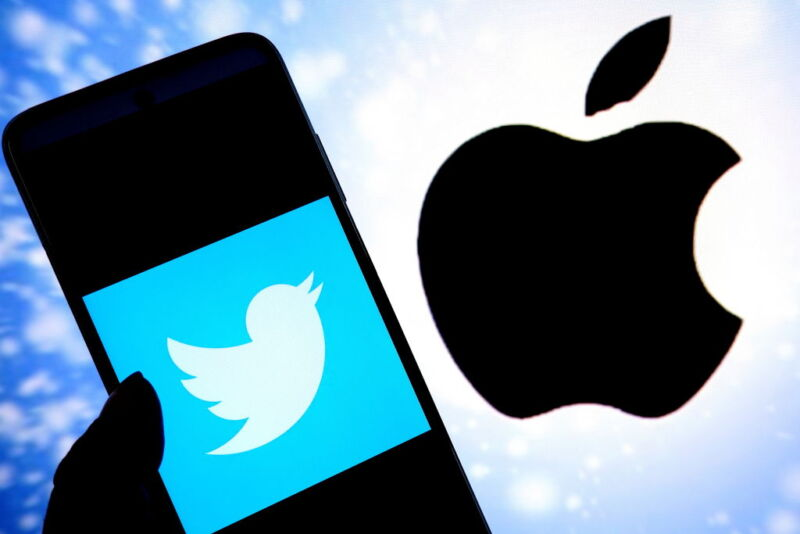

## Overview:
Data Analysis, Natural Language Processing and Iterative Machine Learning Modeling performed on twitter data for Apple Inc.

# Business Problem:
Apple Inc. wants to determine sentiment around their products and develop a deployable model which can determine product/brand sentiment

## Data Understanding
- 9,093 tweets sourced from CrowdFlower via data.world.
- Tweets from 2013 South by Southwest tech conference and music festival.
- Human labeled Target Column classifying sentiment of tweet as positive, negative, neutral, or can't tell. 

**Bias**
- Twitter userbase is 56.4% male and SXSW attendees are 55% male.
- 74% of SXSW attendees are between the ages of 18 and 44.
- 80.2% of Twitter/X userbase are between the ages of 18-44.

**Limitations**
- Data from 2013, apple products and services have evolved since then.
- Sentiment Target is imbalanced in the data. Only 8% of tweets are negative sentiment.

- Imports

In [436]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from wordcloud import WordCloud
warnings.filterwarnings('ignore')
import nltk
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from nltk.tokenize import RegexpTokenizer
from nltk import FreqDist
from matplotlib.ticker import MaxNLocator
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from nltk.stem.snowball import SnowballStemmer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from wordcloud import WordCloud
from wordcloud import STOPWORDS

-  Reading in the Data and examining it

In [437]:
df = pd.read_csv("data/tweet_product_company.csv", encoding = 'latin-1')

In [438]:
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [439]:
df.tail()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product
9092,Ï¡Ïàü_ÊÎÒ£Áââ_£â_ÛâRT @...,NaN,No emotion toward brand or product


In [440]:
df.describe()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
count,9092,3291,9093
unique,9065,9,4
top,RT @mention Marissa Mayer: Google Will Connect...,iPad,No emotion toward brand or product
freq,5,946,5389


In [441]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


- Lowercasing tweet text lower and filtering by any tweets that contain Apple related terms

In [442]:
df['tweet_text_lower'] = df['tweet_text'].str.lower()

Checking if any Apple terms are in tweet_text to work with all apple related tweets since there are many missing values in
'emotion_in_tweet_is_directed_at'

In [443]:
apple_related = 'ipad|apple|iphone|itunes'

In [444]:
df['tweet_text_lower'].str.contains(apple_related).sum()

5592

In [445]:
df.shape

(9093, 4)

Dropping the one row with missing tweet_text

In [446]:
df.dropna(subset=['tweet_text'], inplace=True)

Instantiating apple_df which will be the main dataframe our analysis will focus on.

In [447]:
apple_df = df[df['tweet_text_lower'].str.contains(apple_related)].copy()

In [448]:
apple_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5592 entries, 0 to 9091
Data columns (total 4 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          5592 non-null   object
 1   emotion_in_tweet_is_directed_at                     2417 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  5592 non-null   object
 3   tweet_text_lower                                    5592 non-null   object
dtypes: object(4)
memory usage: 218.4+ KB


In [449]:
apple_df['emotion_in_tweet_is_directed_at'].value_counts()

iPad                               946
Apple                              659
iPad or iPhone App                 454
iPhone                             296
Other Apple product or service      35
Android                              9
Android App                          8
Google                               7
Other Google product or service      3
Name: emotion_in_tweet_is_directed_at, dtype: int64

Dropping Columns 'emotion_in_tweet_is_direct_at' because we have focused on all Apple related tweets already and will analyze sentiment from there.

In [450]:
apple_df.drop(columns=['emotion_in_tweet_is_directed_at', 'tweet_text_lower'], axis=1, inplace=True)

In [451]:
apple_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5592 entries, 0 to 9091
Data columns (total 2 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          5592 non-null   object
 1   is_there_an_emotion_directed_at_a_brand_or_product  5592 non-null   object
dtypes: object(2)
memory usage: 131.1+ KB


In [452]:
# Renaming target column to "emotion"
apple_df.rename(columns={"is_there_an_emotion_directed_at_a_brand_or_product": "emotion"}, inplace=True)

In [453]:
apple_df['emotion'].value_counts()

No emotion toward brand or product    2929
Positive emotion                      2144
Negative emotion                       420
I can't tell                            99
Name: emotion, dtype: int64

In [454]:
apple_df.head()

,tweet_text,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,Negative emotion
5,@teachntech00 New iPad Apps For #SpeechTherapy...,No emotion toward brand or product


In [455]:
apple_df['emotion'] = apple_df['emotion'].replace("I can't tell", "No emotion toward brand or product")
apple_df['emotion'] = apple_df['emotion'].replace("No emotion toward brand or product", "Neutral Emotion")

- Visualizing distribution of emotion sentiment target in the corpus.

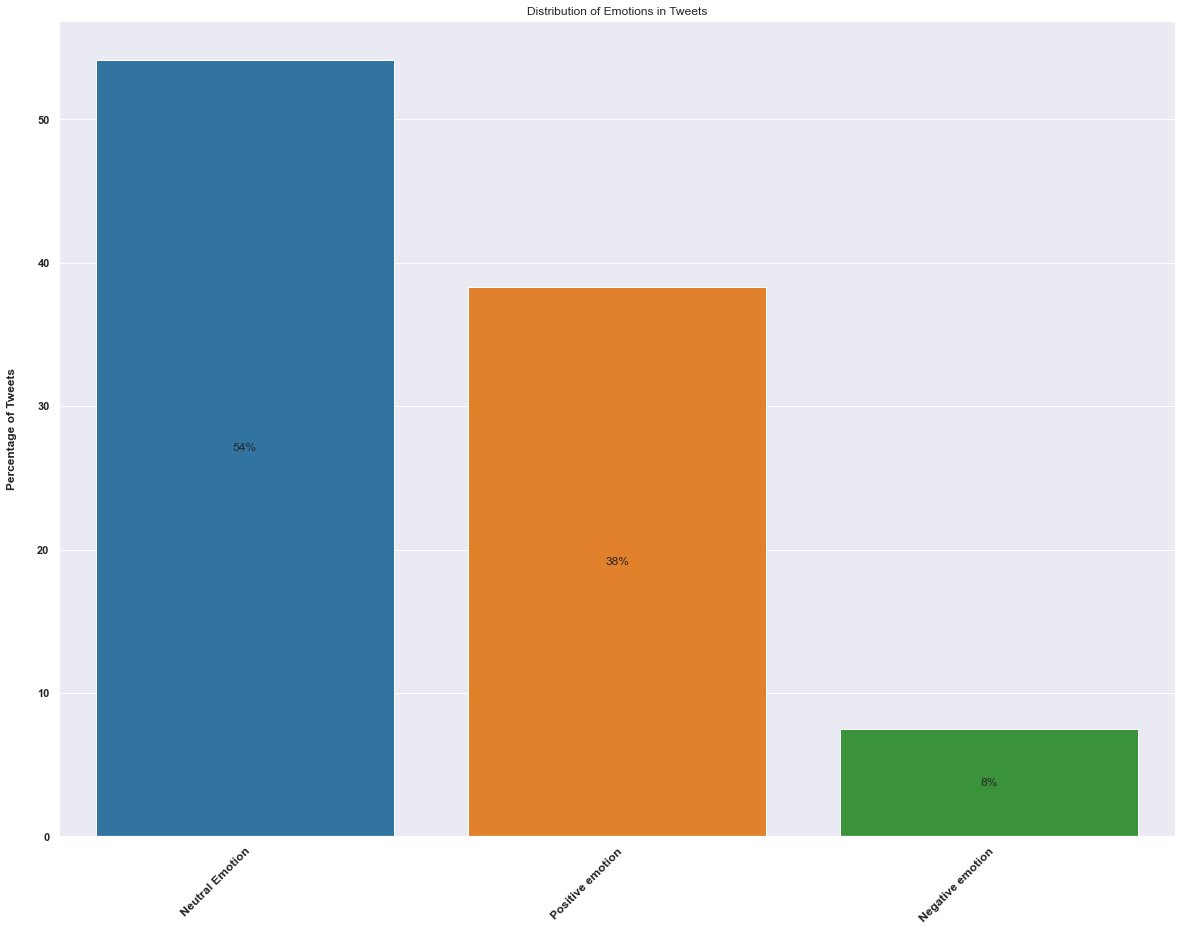

In [456]:
sns.set_context("notebook")
sns.set_style("darkgrid")
plt.figure(figsize =(20,15))
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontsize='medium',
    fontweight='bold',
    wrap=True,
)
plt.yticks(fontweight='bold')

percentage_df = apple_df['emotion'].value_counts(normalize=True) * 100

ax = sns.barplot(
    x=percentage_df.index, 
    y=percentage_df.values
)
ax.bar_label(ax.containers[0],fmt='%.0f%%', label_type='center')

plt.title("Distribution of Emotions in Tweets")
plt.ylabel('Percentage of Tweets', fontweight='bold', labelpad=20, fontsize='medium')
plt.xlabel(None)
plt.show()

Emotion is unbalanced target with much fewer negative tweets.

In [457]:
apple_df.head()

,tweet_text,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,Negative emotion
5,@teachntech00 New iPad Apps For #SpeechTherapy...,Neutral Emotion


In [458]:
apple_df.duplicated().sum()

5

In [459]:
# Dropping duplicate rows
apple_df.drop_duplicates(inplace=True)

In [460]:
apple_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5587 entries, 0 to 9091
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweet_text  5587 non-null   object
 1   emotion     5587 non-null   object
dtypes: object(2)
memory usage: 130.9+ KB


- Encoding the emotional target from strings to integers 0-2 and combining "neutral and can't tell" into "neutral"

In [461]:
def custom_encoder(apple_df):
    apple_df.replace(to_replace ="Neutral Emotion", value =2, inplace=True)
    apple_df.replace(to_replace ="Positive emotion", value =1, inplace=True)
    apple_df.replace(to_replace ="Negative emotion", value =0, inplace=True)

In [462]:
custom_encoder(apple_df['emotion'])

In [463]:
apple_df['emotion'].value_counts()

2    3028
1    2140
0     419
Name: emotion, dtype: int64

In [464]:
apple_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5587 entries, 0 to 9091
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweet_text  5587 non-null   object
 1   emotion     5587 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 130.9+ KB


# Train Test Split

In [465]:
apple_df = apple_df.copy()

In [466]:
X = apple_df.drop(columns=['emotion'], axis=1)
y = apple_df['emotion']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [467]:
train_sample = X_train.sample(5, random_state=42)
train_sample.style.set_properties(**{'text-align': 'left'})

,tweet_text
5039,RT @mention : Aron Pilhofer from The New York Times just endorsed HTML over iPad at the #NewsApps #sxsw and asked us not to tweet...
3852,@mention is an out-of-town douchebag selling his new ipad 2 above sticker price. {link} #sxsw
5423,RT @mention Apple has opened a pop-up store in Austin so that the nerds in town for #SXSW can get their new iPads. {link}
192,The #iPad 2 Takes Over #SXSW [VIDEO] /by @mention {link}
2911,"To my friends at #SXSW who think I abandoned you, in reality I just didn't have any means of communication, my iPhone stopped working. #fail"


## Preprocessing

-Starting with lowercasing

In [468]:
X_train["tweet_text"] = X_train["tweet_text"].str.lower()

In [469]:
X_train.iloc[100]['tweet_text']

'\x89ûï@mention new #ubersocial for #iphone now in the app store includes uberguide to #sxsw sponsored by #mashable\x89û\x9d @mention vamos a probar...'

In [470]:
basic_token_pattern = r"(?u)\b\w\w+\b"

tokenizer = RegexpTokenizer(basic_token_pattern)

In [471]:
X_train["text_tokenized"] = X_train["tweet_text"].apply(tokenizer.tokenize)

In [472]:
X_train.iloc[100]["text_tokenized"][:20]

['ûï',
 'mention',
 'new',
 'ubersocial',
 'for',
 'iphone',
 'now',
 'in',
 'the',
 'app',
 'store',
 'includes',
 'uberguide',
 'to',
 'sxsw',
 'sponsored',
 'by',
 'mashable',
 'mention',
 'vamos']

In [473]:
train_freq_dist = FreqDist(X_train["text_tokenized"].explode())

- A Function to visualize top 10 words we will use throughout to assist in analysis.

In [474]:
def visualize_top_10(freq_dist, title):
    
    top_10 = list(zip(*freq_dist.most_common(10)))
    tokens = top_10[0]
    counts = top_10[1]
    
    fig, ax = plt.subplots()
    ax.bar(tokens, counts)
    
    ax.set_title(title)
    ax.set_ylabel("Count")
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.tick_params(axis="x", rotation=45)    

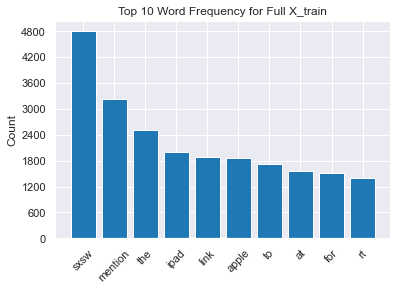

In [475]:
visualize_top_10(train_freq_dist, "Top 10 Word Frequency for Full X_train")

 - Dropping emotion_in_tweet_is_directed_at for now just to analyze tweets and overall sentiment irregardless of brand.

- 2 functions that to be used in conjunction with visualize_top_10 to visualize top 10 words among the 3 sentiment targets with different preprocessing steps applied throught analysis.

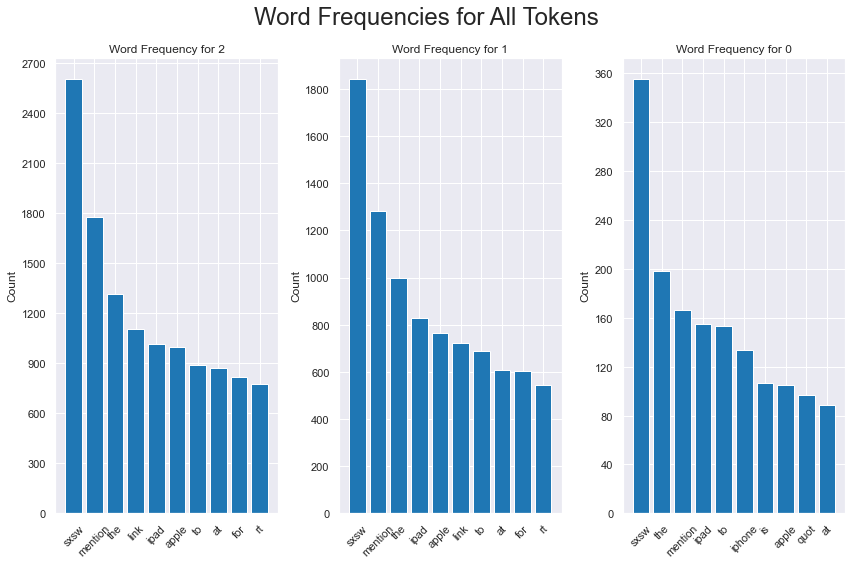

In [476]:
X_train["emotion"] = [y_train[val] for val in X_train.index]

def setup_three_subplots():
    
    fig = plt.figure(figsize=(12,8))
    fig.set_tight_layout(True)
    gs = fig.add_gridspec(1, 6)
    ax1 = fig.add_subplot(gs[0, :2]) # row 0, cols 0-1
    ax2 = fig.add_subplot(gs[0, 2:4])# row 0, cols 2-3
    ax3 = fig.add_subplot(gs[0, 4:]) # row 0, cols 4-5
    return fig, [ax1, ax2, ax3]

def plot_distribution_of_column_by_category(column, axes, title="Word Frequency for"):
    unique_categories = X_train["emotion"].unique()
    
    if len(axes) < len(unique_categories):
        raise ValueError("If the number of subplots is less than the number of unique categories.")
    
    for category, ax in zip(unique_categories, axes):
        # Calculate frequency distribution for this subset
        all_words = X_train[X_train["emotion"] == category][column].explode()
        freq_dist = FreqDist(all_words)
        top_10 = list(zip(*freq_dist.most_common(10)))
        
        tokens = top_10[0]
        counts = top_10[1]

        # Set up plot
        ax.bar(tokens, counts)

        # Customize plot appearance
        ax.set_title(f"{title} {category}")
        ax.set_ylabel("Count")
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        ax.tick_params(axis="x", rotation=45)


fig, axes = setup_three_subplots()
plot_distribution_of_column_by_category("text_tokenized", axes)
fig.suptitle("Word Frequencies for All Tokens", fontsize=24);

- Setting up a baseline Multinomial Naive Bayes model with TfidfVectorizer vectorized corpus.

In [477]:
tfidf = TfidfVectorizer(max_features=10)

X_train_vectorized = tfidf.fit_transform(X_train["tweet_text"])

pd.DataFrame.sparse.from_spmatrix(X_train_vectorized, columns=tfidf.get_feature_names())

,apple,at,for,ipad,link,mention,rt,sxsw,the,to
0,0.891189,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.453632,0.000000,0.000000
1,0.000000,0.292554,0.000000,0.502628,0.000000,0.681696,0.307907,0.136207,0.000000,0.289323
2,0.000000,0.000000,0.724397,0.606089,0.000000,0.000000,0.000000,0.328489,0.000000,0.000000
3,0.000000,0.000000,0.460931,0.000000,0.394898,0.000000,0.000000,0.209016,0.766753,0.000000
4,0.427662,0.000000,0.000000,0.000000,0.000000,0.726329,0.492101,0.217688,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
4464,0.471426,0.515410,0.000000,0.000000,0.000000,0.400329,0.542460,0.239965,0.000000,0.000000
4465,0.000000,0.390823,0.000000,0.000000,0.000000,0.607119,0.000000,0.181960,0.667499,0.000000
4466,0.000000,0.000000,0.000000,0.389231,0.398563,0.703866,0.000000,0.210956,0.386934,0.000000
4467,0.000000,0.000000,0.615496,0.514974,0.527320,0.000000,0.000000,0.279106,0.000000,0.000000


Double checking the shape of vectorized data. Same number of rows and 10 columns because max_features=10

In [478]:
assert X_train_vectorized.shape[0] == X_train.shape[0]
assert X_train_vectorized.shape[1] == 10

Fitting and cross-validation evaluating a Multinomial Naive Bayes Classification model as baseline model

In [479]:
baseline_model = MultinomialNB()

baseline_cv = cross_val_score(baseline_model, X_train_vectorized, y_train)
baseline_cv.mean()

0.53680903672862

In [480]:
y_train.value_counts(normalize=True)

2    0.536809
1    0.386664
0    0.076527
Name: emotion, dtype: float64

This model appears to guess the majority class of neutral with almost exactly the same accuracy that it appears. 

# Iterating upon the model using different Prepocessing and Feature Engineering

- Removing Stopwords

In [481]:
nltk.download('stopwords', quiet=True)

stopwords_list = stopwords.words('english')

- Adding stopwords that we deemed semantically insignificant based on domain knowledge and examining sample tweets.

In [482]:
stopwords_list.extend(['sxsw','iphone','ipad','apple','','mention','link','rt','austin','store','2','quot','popup', 'ipad2', 'ipads', 'relie', 'amp'])


In [483]:
stopwords_list[-10:]

['rt',
 'austin',
 'store',
 '2',
 'quot',
 'popup',
 'ipad2',
 'ipads',
 'relie',
 'amp']

- Making a function to remove stopwords and applying it to X_train

In [484]:
def remove_stopwords(token_list):
    
    stopwords_removed = [token for token in token_list if token not in stopwords_list]
    return stopwords_removed

In [485]:
X_train["text_without_stopwords"] = X_train["text_tokenized"].apply(remove_stopwords)

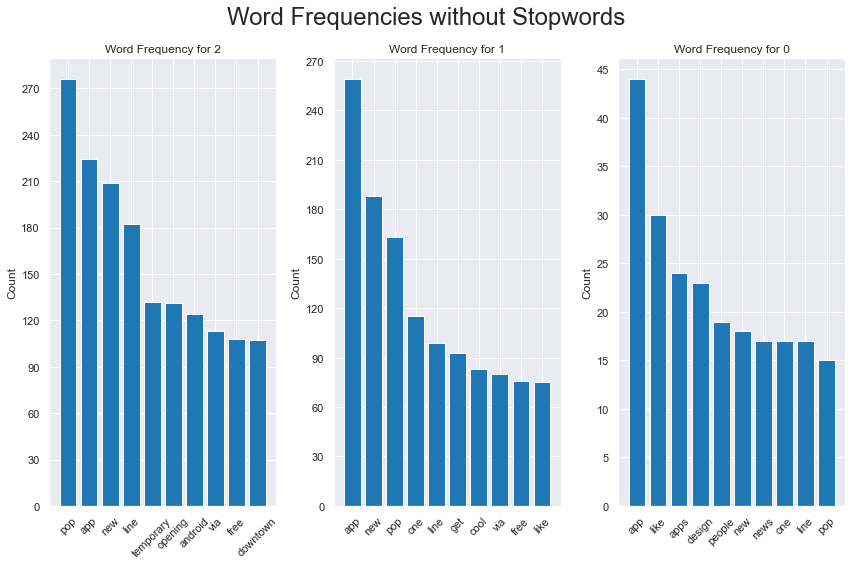

In [486]:
fig, axes = setup_three_subplots()
plot_distribution_of_column_by_category("text_without_stopwords", axes)
fig.suptitle("Word Frequencies without Stopwords", fontsize=24);

# Making a wordcloud to visualize frequently occurring significant words

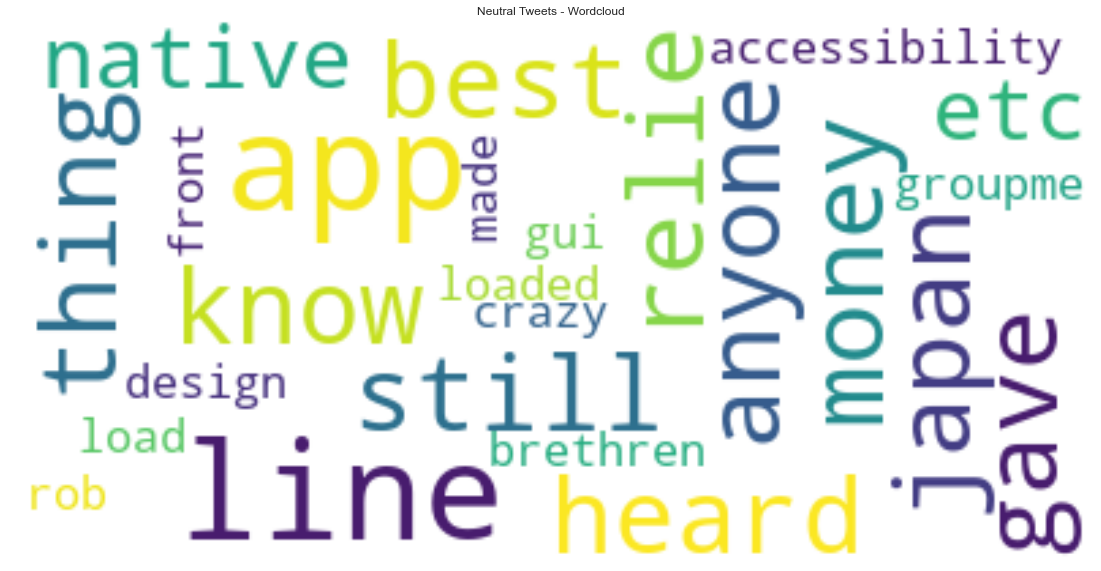

In [487]:
neutral_tweets = X_train[(X_train["emotion"] == 2)]
neutral_wordcloud = WordCloud(
    max_font_size=50, 
    max_words=25, 
    background_color="white").generate(str(neutral_tweets['text_without_stopwords']))
plt.figure(figsize=(20, 10))
plt.title("Neutral Tweets - Wordcloud")
plt.imshow(neutral_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [488]:
# Block of code used to check tweets containing keywords assigned to variable 'search_string'
search_string = 'via'

filtered_rows = neutral_tweets[neutral_tweets['tweet_text'].str.contains(search_string)]
filtered_rows.style.set_properties(**{'text-align': 'left'})

,tweet_text,text_tokenized,emotion,text_without_stopwords
7083,apple to open temporary store at sxsw | tipb {link} via @mention #sxsw,"['apple', 'to', 'open', 'temporary', 'store', 'at', 'sxsw', 'tipb', 'link', 'via', 'mention', 'sxsw']",2,"['open', 'temporary', 'tipb', 'via']"
4730,apple opens pop up store at sxsw {link} via @mention #apple #ipad2 #technology #itunes #sxsw,"['apple', 'opens', 'pop', 'up', 'store', 'at', 'sxsw', 'link', 'via', 'mention', 'apple', 'ipad2', 'technology', 'itunes', 'sxsw']",2,"['opens', 'pop', 'via', 'technology', 'itunes']"
1441,confirmed! apple store 2 week popup in austin for #sxsw now with picture! {link} ( via @mention who gave us no credit! ),"['confirmed', 'apple', 'store', 'week', 'popup', 'in', 'austin', 'for', 'sxsw', 'now', 'with', 'picture', 'link', 'via', 'mention', 'who', 'gave', 'us', 'no', 'credit']",2,"['confirmed', 'week', 'picture', 'via', 'gave', 'us', 'credit']"
4044,apple will open a popup store friday at 6th and congress. #sxsw via satesman.com,"['apple', 'will', 'open', 'popup', 'store', 'friday', 'at', '6th', 'and', 'congress', 'sxsw', 'via', 'satesman', 'com']",2,"['open', 'friday', '6th', 'congress', 'via', 'satesman', 'com']"
7099,apple is opening up a temp store in austin for #sxsw {link} via @mention #ipad2,"['apple', 'is', 'opening', 'up', 'temp', 'store', 'in', 'austin', 'for', 'sxsw', 'link', 'via', 'mention', 'ipad2']",2,"['opening', 'temp', 'via']"
2982,watch someone 'hack' times square tv screens with an iphone (via @mention {link} #sxsw #tech #amazing #winning,"['watch', 'someone', 'hack', 'times', 'square', 'tv', 'screens', 'with', 'an', 'iphone', 'via', 'mention', 'link', 'sxsw', 'tech', 'amazing', 'winning']",2,"['watch', 'someone', 'hack', 'times', 'square', 'tv', 'screens', 'via', 'tech', 'amazing', 'winning']"
1871,"#sxsw ûò rackspace startup program, cloud 2.0 #ipad app launched {link} via @mention","['sxsw', 'ûò', 'rackspace', 'startup', 'program', 'cloud', 'ipad', 'app', 'launched', 'link', 'via', 'mention']",2,"['ûò', 'rackspace', 'startup', 'program', 'cloud', 'app', 'launched', 'via']"
8059,get a personalized sxsw show schedule via app from... {link} #mobile_apps #music #echo_nest #rhapsody #sxsw #cyber #iphone,"['get', 'personalized', 'sxsw', 'show', 'schedule', 'via', 'app', 'from', 'link', 'mobile_apps', 'music', 'echo_nest', 'rhapsody', 'sxsw', 'cyber', 'iphone']",2,"['get', 'personalized', 'show', 'schedule', 'via', 'app', 'mobile_apps', 'music', 'echo_nest', 'rhapsody', 'cyber']"
6680,rt @mention spearheading #japan disaster relief from #sxsw via #twitter & #iphone (#socialgood #philanthropy) {link},"['rt', 'mention', 'spearheading', 'japan', 'disaster', 'relief', 'from', 'sxsw', 'via', 'twitter', 'amp', 'iphone', 'socialgood', 'philanthropy', 'link']",2,"['spearheading', 'japan', 'disaster', 'relief', 'via', 'twitter', 'socialgood', 'philanthropy']"
1159,ûï@mention the ipad 2 takes over #sxsw [video]: {link} via mashableû,"['ûï', 'mention', 'the', 'ipad', 'takes', 'over', 'sxsw', 'video', 'link', 'via', 'mashable']",2,"['ûï', 'takes', 'video', 'via', 'mashable']"


- Vectorizing and Fitting model removing custom stopwords list to evaluate model performance.

In [489]:
tfidf = TfidfVectorizer(
    max_features=10,
    stop_words=stopwords_list)

X_train_vectorized = tfidf.fit_transform(X_train["tweet_text"])

pd.DataFrame.sparse.from_spmatrix(X_train_vectorized, columns=tfidf.get_feature_names())

,app,free,get,line,new,one,opening,pop,temporary,via
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
4464,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4465,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4466,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4467,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [490]:
stopwords_removed_cv = cross_val_score(baseline_model, X_train_vectorized, y_train)
stopwords_removed_cv.mean()

0.5518041140263196

In [491]:
print("Baseline:         ", baseline_cv.mean())
print("Stopwords removed:", stopwords_removed_cv.mean())

Baseline:          0.53680903672862
Stopwords removed: 0.5518041140263196


- Removing custom stopwords list improved accuracy by around 2%.

# Lemmatizing tokens to see if it improves model performance.

In [492]:
lemmatizer = WordNetLemmatizer()

def lemmatize_and_tokenize(document):
    tokens = tokenizer.tokenize(document)
    return [lemmatizer.lemmatize(token) for token in tokens]


In [493]:
lemmatized_stopwords = [lemmatizer.lemmatize(word) for word in stopwords_list]

In [494]:
tfidf = TfidfVectorizer(
    max_features=10,
    stop_words = lemmatized_stopwords,
    tokenizer = lemmatize_and_tokenize
)

X_train_vectorized = tfidf.fit_transform(X_train["tweet_text"])

pd.DataFrame.sparse.from_spmatrix(X_train_vectorized, columns=tfidf.get_feature_names())

,app,get,line,new,one,open,opening,pop,temporary,via
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
4464,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4465,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4466,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4467,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [495]:
lemmatized_cv = cross_val_score(baseline_model, X_train_vectorized, y_train)
lemmatized_cv.mean()

0.5529224317397807

In [496]:
print("Stopwords removed:", stopwords_removed_cv.mean())
print("Lemmatized:          ", lemmatized_cv.mean())

Stopwords removed: 0.5518041140263196
Lemmatized:           0.5529224317397807


- Lemmatization improved model performance by .1%

# Stemming tokens to see if it improves model performance.

In [497]:
stemmer = SnowballStemmer(language="english")

def stem_and_tokenize(document):
    tokens = tokenizer.tokenize(document)
    return [stemmer.stem(token) for token in tokens]

In [498]:
stemmed_stopwords = [stemmer.stem(word) for word in stopwords_list]

In [499]:
tfidf = TfidfVectorizer(
    max_features = 10,
    stop_words = stemmed_stopwords,
    tokenizer = stem_and_tokenize
)

X_train_vectorized = tfidf.fit_transform(X_train["tweet_text"])

pd.DataFrame.sparse.from_spmatrix(X_train_vectorized, columns=tfidf.get_feature_names())

,app,get,go,line,new,one,open,pop,temporari,via
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
4464,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4465,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4466,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4467,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [500]:
stemmed_cv = cross_val_score(baseline_model, X_train_vectorized, y_train)

In [501]:
print("Stopwords removed:", stopwords_removed_cv.mean())
print("Stemmed:          ", stemmed_cv.mean())

Stopwords removed: 0.5518041140263196
Stemmed:           0.5372587186944944


- Stemming decreased performance of the model so we will not use Stemming in our model.

# Feature engineering - will add number of sentences and whether tweet has an emoji columns

- Adding column 'num_sentences" to add feature column to our model.

In [502]:
X_train["num_sentences"] = X_train["tweet_text"].apply(lambda x: len(sent_tokenize(x)))

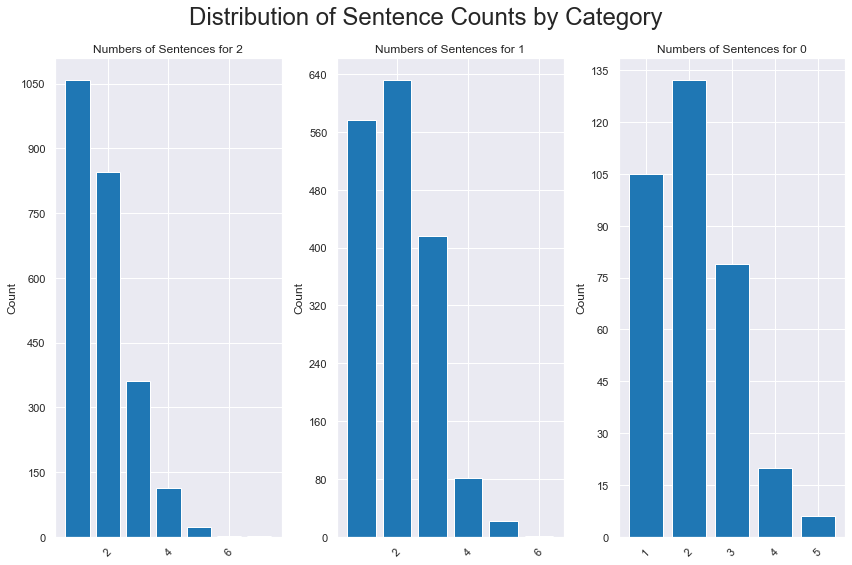

In [503]:
fig, axes = setup_three_subplots()
plot_distribution_of_column_by_category("num_sentences", axes, "Numbers of Sentences for")
fig.suptitle("Distribution of Sentence Counts by Category", fontsize=24);

- Adding "contains_emoji" column to add another feature column to our model.

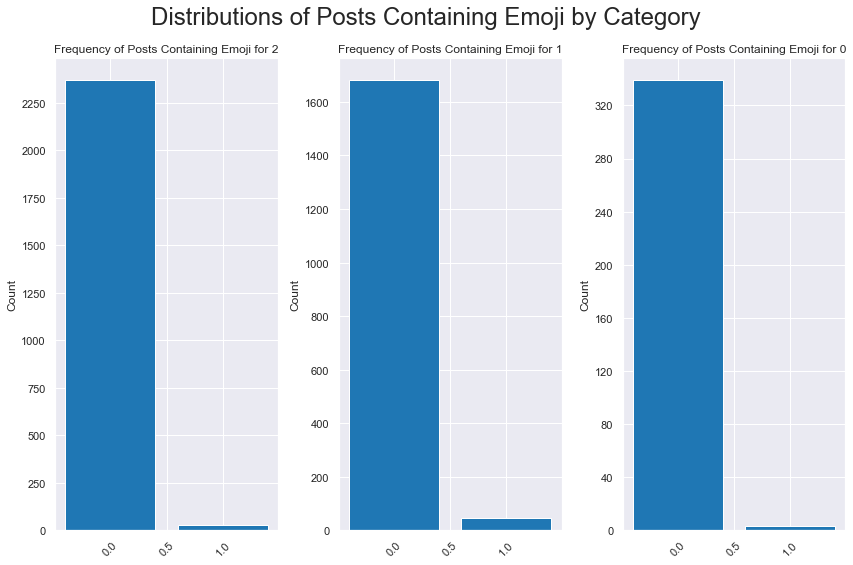

In [504]:
emoji_query = r'(?:[\:;X=B][-^]?[)\]3D([OP/\\|])(?:(?=\s))'

X_train["contains_emoji"] = X_train["tweet_text"].str.contains(emoji_query)

fig, axes = setup_three_subplots()
plot_distribution_of_column_by_category("contains_emoji", axes, "Frequency of Posts Containing Emoji for")
fig.suptitle("Distributions of Posts Containing Emoji by Category", fontsize=24);

It appears that positive posts might emoji's at a slightly higher rate which would make sense because a smiley face is probably the most common emoji and it would most likely be in a positive emotion tweet.

- Combining new columns with lemmatized tokens and evaluating model performance.

In [505]:
tfidf = TfidfVectorizer(
    max_features=10,
    stop_words = lemmatized_stopwords,
    tokenizer = lemmatize_and_tokenize
)

X_train_vectorized = tfidf.fit_transform(X_train["tweet_text"])

pd.DataFrame.sparse.from_spmatrix(X_train_vectorized, columns=tfidf.get_feature_names())

X_train_vectorized_df = pd.DataFrame(X_train_vectorized.toarray(), columns=tfidf.get_feature_names())

In [506]:
### Concatenating the engineered features in a new DataFrame 'preprocessed_X_train'
preprocessed_X_train = pd.concat([
    X_train_vectorized_df.reset_index(drop=True), X_train[["num_sentences", "contains_emoji"]].reset_index(drop=True)
], axis = 1,)

preprocessed_X_train

,app,get,line,new,one,open,opening,pop,temporary,via,num_sentences,contains_emoji
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,False
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,False
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,False
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,True
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...
4464,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3,False
4465,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2,False
4466,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,False
4467,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,False


In [507]:
preprocessed_cv = cross_val_score(baseline_model, preprocessed_X_train, y_train)

In [508]:
print("Lemmatized:           ", lemmatized_cv.mean())
print("Fully preprocessed:", preprocessed_cv.mean())

Lemmatized:            0.5529224317397807
Fully preprocessed: 0.5542639620613722


- Adding the two engineered features 'num_sentences' and 'contains_emoji' improved accuracy by .2 percent

In [509]:
X_train

,tweet_text,text_tokenized,emotion,text_without_stopwords,num_sentences,contains_emoji
7262,anyone know if #sxsw apple store still has ipads?,"[anyone, know, if, sxsw, apple, store, still, ...",2,"[anyone, know, still]",1,False
5559,rt @mention best thing heard at #sxsw &quot;i ...,"[rt, mention, best, thing, heard, at, sxsw, qu...",2,"[best, thing, heard, gave, money, japan, relie...",2,False
7482,"native apps for ipad, etc., now have their own...","[native, apps, for, ipad, etc, now, have, thei...",2,"[native, apps, etc, accessibility, design, gui...",3,False
1898,i just loaded up the groupme app for the iphon...,"[just, loaded, up, the, groupme, app, for, the...",2,"[loaded, groupme, app, load, brethren]",3,True
6130,rt @mention in line with @mention and rob ... ...,"[rt, mention, in, line, with, mention, and, ro...",2,"[line, rob]",1,False
...,...,...,...,...,...,...
6172,rt @mention it's crazy here at #apple's tempor...,"[rt, mention, it, crazy, here, at, apple, temp...",2,"[crazy, temporary, post, coming, pics]",3,False
8449,enjoying the resurgence ûï@mention i'll be at...,"[enjoying, the, resurgence, ûï, mention, ll, b...",2,"[enjoying, resurgence, ûï, convention, center,...",2,False
8507,help @mention advance in the techstars @mentio...,"[help, mention, advance, in, the, techstars, m...",2,"[help, advance, techstars, getoutthevote, star...",1,False
8794,photo: saving up for an ipad 2 #sxsw style! #h...,"[photo, saving, up, for, an, ipad, sxsw, style...",1,"[photo, saving, style, hpsxsw, taken, instagram]",2,False


## Pipeline and Gridsearch to find the best parameters for our model

In [510]:
# Split the data into training and testing sets
X_train1, X_test1, y_train1, y_test1 = train_test_split(apple_df['tweet_text'], apple_df['emotion'], test_size=0.2, random_state=42)

# Create a pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('classifier', MultinomialNB())
])

# Define the parameter grid
parameter_grid = {
    'tfidf__max_features': [1000, 2000, 3000],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'classifier__alpha': [0.1, 0.5, 1.0]
}

# Perform grid search using cross-validation
grid_search = GridSearchCV(pipeline, parameter_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train1, y_train1)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Make predictions on the testing data using the best model
y_pred = grid_search.predict(X_test1)

# Evaluate the performance of the best model
report = classification_report(y_test1, y_pred)
print(report)

# Print the best parameters and best score
print("Best Parameters:", best_params)
print("Best Score:", best_score)


              precision    recall  f1-score   support

           0       1.00      0.08      0.14        77
           1       0.66      0.45      0.54       412
           2       0.66      0.87      0.75       629

    accuracy                           0.66      1118
   macro avg       0.77      0.47      0.48      1118
weighted avg       0.68      0.66      0.63      1118

Best Parameters: {'classifier__alpha': 0.5, 'tfidf__max_features': 2000, 'tfidf__ngram_range': (1, 1)}
Best Score: 0.6256428948996795


- Vectorizing corpus with max_features=2000 based off gridsearch determined best parameters

In [511]:
tfidf = TfidfVectorizer(
    max_features = 2000,
    stop_words = lemmatized_stopwords,
    tokenizer = lemmatize_and_tokenize
)

X_train_vectorized = tfidf.fit_transform(X_train["tweet_text"])

pd.DataFrame.sparse.from_spmatrix(X_train_vectorized, columns=tfidf.get_feature_names())

X_train_vectorized_df = pd.DataFrame(X_train_vectorized.toarray(), columns=tfidf.get_feature_names())

- Instantiating final_X_train with determined best preprocessing steps and engineered featrues.

In [512]:
final_X_train = pd.concat([
    X_train_vectorized_df.reset_index(drop=True), X_train[["num_sentences", "contains_emoji"]].reset_index(drop=True)
], axis=1)
final_X_train

,000,00am,03,10,100,11,12,13,14,1413,...,ûªll,ûªm,ûªre,ûªs,ûªt,ûï,ûò,ûó,num_sentences,contains_emoji
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1,False
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,2,False
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,3,False
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,3,True
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4464,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,3,False
4465,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.296415,0.0,0.0,2,False
4466,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1,False
4467,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,2,False


- Cross validation score with final_X_train

In [513]:
final_cv = cross_val_score(baseline_model, final_X_train, y_train)
print("Preprocessed:           ", preprocessed_cv.mean())
print("Final More Features:", final_cv.mean())

Preprocessed:            0.5542639620613722
Final More Features: 0.6178121657134412


- Vectorizing with gridsearch determined best number of max_features (2000) increased models performance by 6%.

- Fitting final model with gridsearch determined best alpha of .5 and scoring performance on training data:

In [514]:
final_model = MultinomialNB(alpha = 0.5)

final_model.fit(final_X_train, y_train)
final_model.score(final_X_train, y_train)

0.7536361602148132

- Final model performs with 75% accuracy on training training data.

Performing the same vectorizing and feature engineering on X_test to perform final evaluation on test holdout data.

In [515]:
X_test_vectorized = tfidf.transform(X_test['tweet_text'])

In [516]:
X_test["num_sentences"] = X_test["tweet_text"].apply(lambda x: len(sent_tokenize(x)))
X_test["contains_emoji"] = X_test["tweet_text"].str.contains(emoji_query)

In [517]:
X_test_vectorized_df = pd.DataFrame(X_test_vectorized.toarray(), columns=tfidf.get_feature_names())
final_X_test = pd.concat([
    X_test_vectorized_df.reset_index(drop=True), X_test[["num_sentences", "contains_emoji"]].reset_index(drop=True)
], axis = 1,)
final_X_test

,000,00am,03,10,100,11,12,13,14,1413,...,ûªll,ûªm,ûªre,ûªs,ûªt,ûï,ûò,ûó,num_sentences,contains_emoji
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,2,False
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1,False
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1,False
3,0.0,0.0,0.0,0.0,0.0,0.430289,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,3,False
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1113,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1,False
1114,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,2,False
1115,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.401846,0.0,0.0,0.0,0.0,1,False
1116,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1,False


In [518]:
final_model.score(final_X_test, y_test)

0.6422182468694096

## Final model performs with 64% accuracy on test data.

- Visualizing Model performance with a confusion matrix display

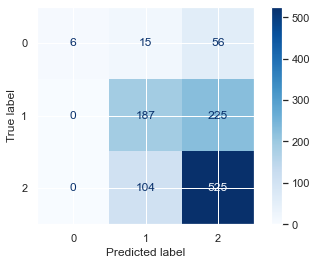

In [519]:
cnf_matrix = confusion_matrix(y_test, final_model.predict(final_X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix, display_labels=final_model.classes_)
disp.plot(cmap=plt.cm.Blues);

- Accurately labeled target column along the upper left to lower right diagonal. The largest mislabeled category are positive posts predicted to be neutral, possibly due to the imbalanced nature of the target with positive and neutral tweets composing 92% of the corpus.